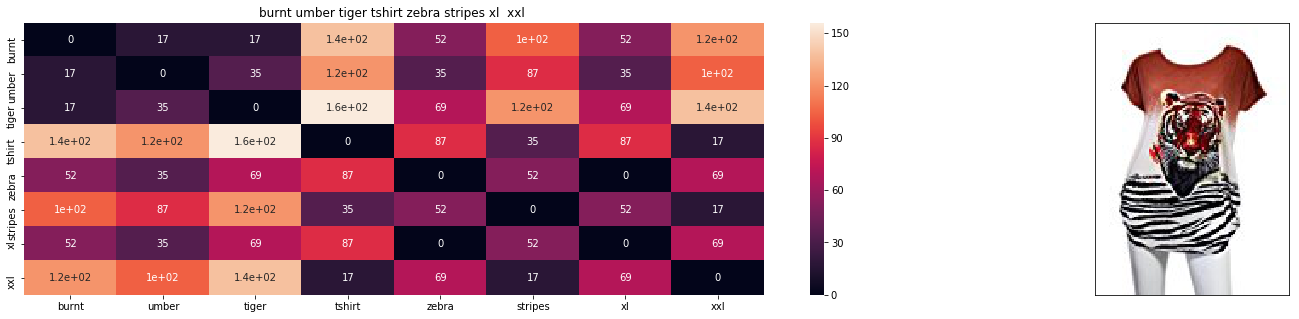

ASIN : B00JXQB5FQ
Brand : Si Row
euclidean distance from input : 0.0144230769231


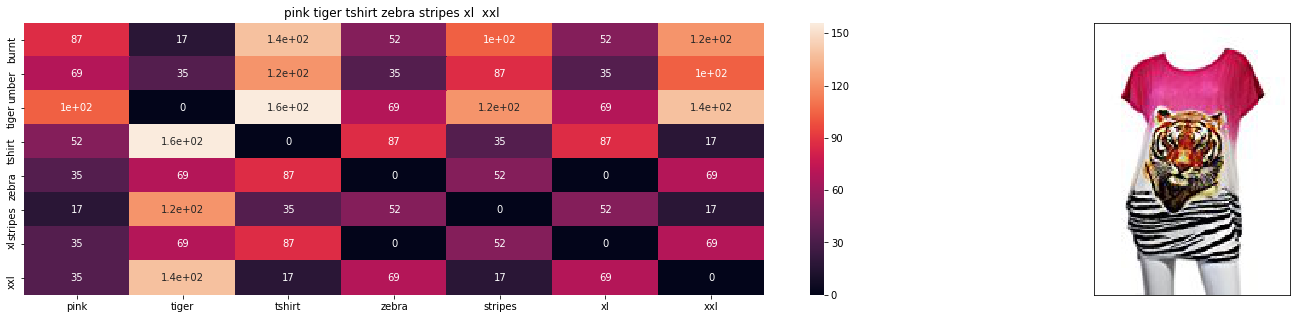

ASIN : B00JXQASS6
Brand : Si Row
euclidean distance from input : 7.47856022775


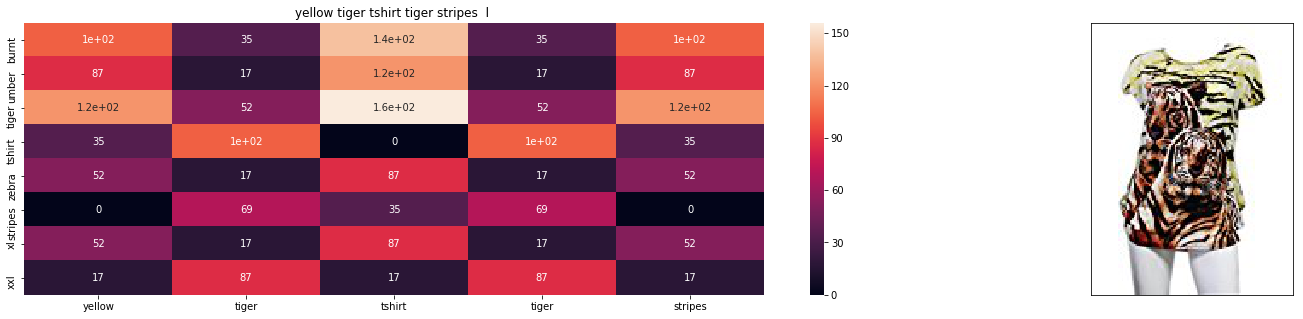

ASIN : B00JXQCUIC
Brand : Si Row
euclidean distance from input : 11.1760255375


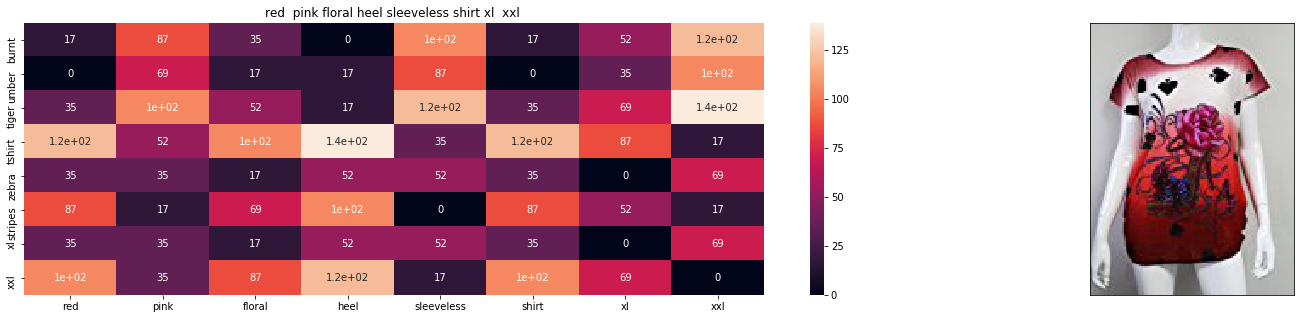

ASIN : B00JV63QQE
Brand : Si Row
euclidean distance from input : 11.6599608203


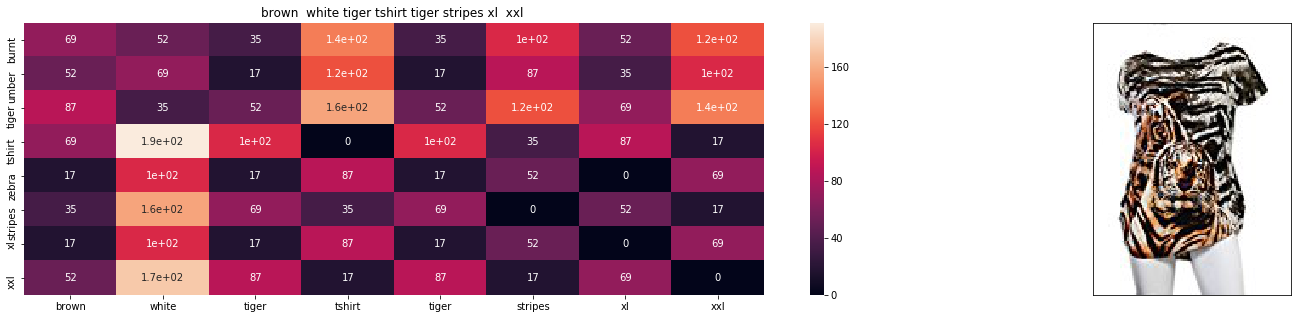

ASIN : B00JXQCWTO
Brand : Si Row
euclidean distance from input : 11.8193231729


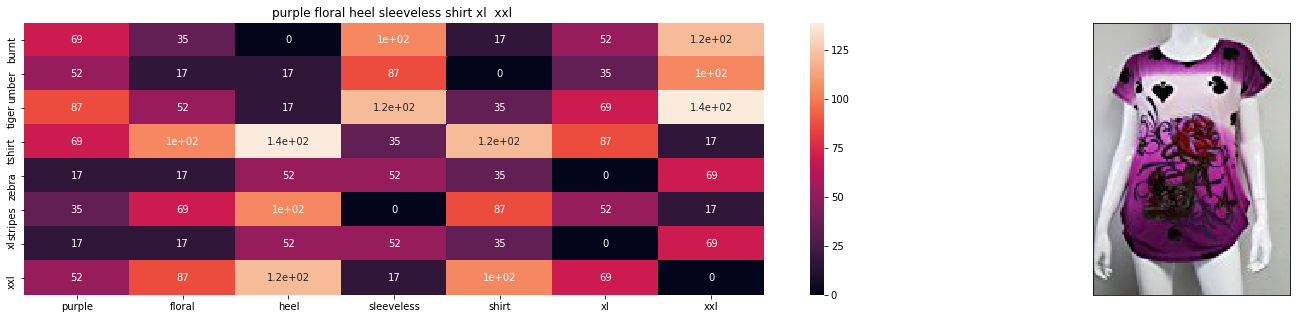

ASIN : B00JV63VC8
Brand : Si Row
euclidean distance from input : 11.8646152204


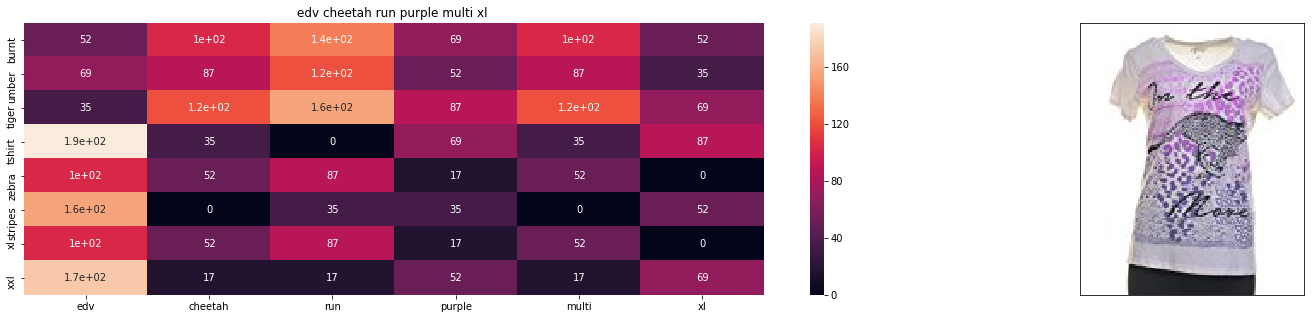

ASIN : B01CUPYBM0
Brand : Styleco
euclidean distance from input : 12.10525488


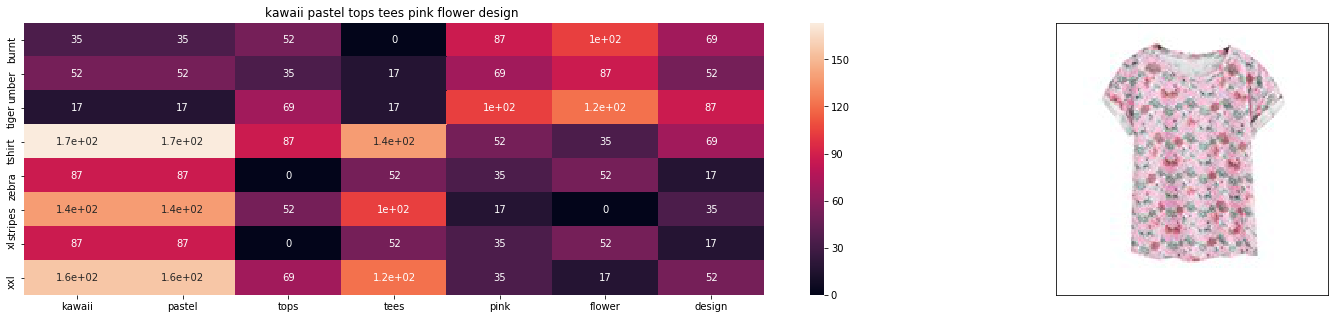

ASIN : B071FCWD97
Brand : Namnoi Clothing Store
euclidean distance from input : 12.1506865794


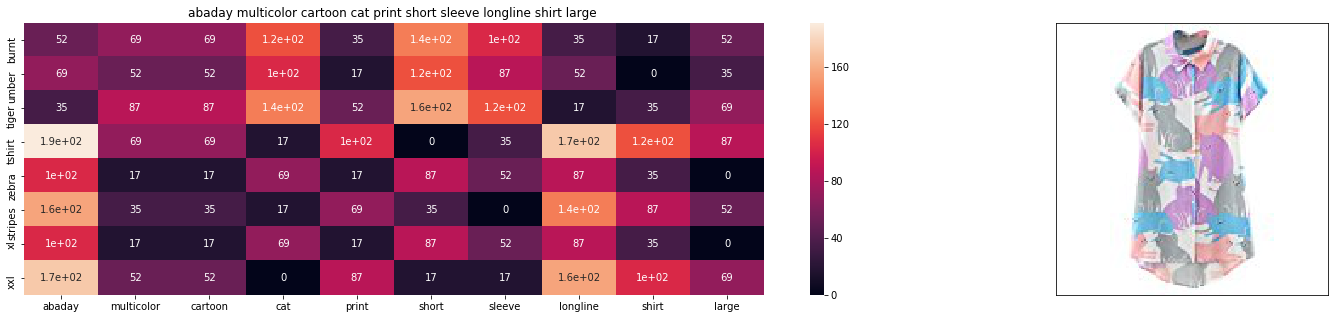

ASIN : B01CR57YY0
Brand : ABADAY
euclidean distance from input : 12.1558201595


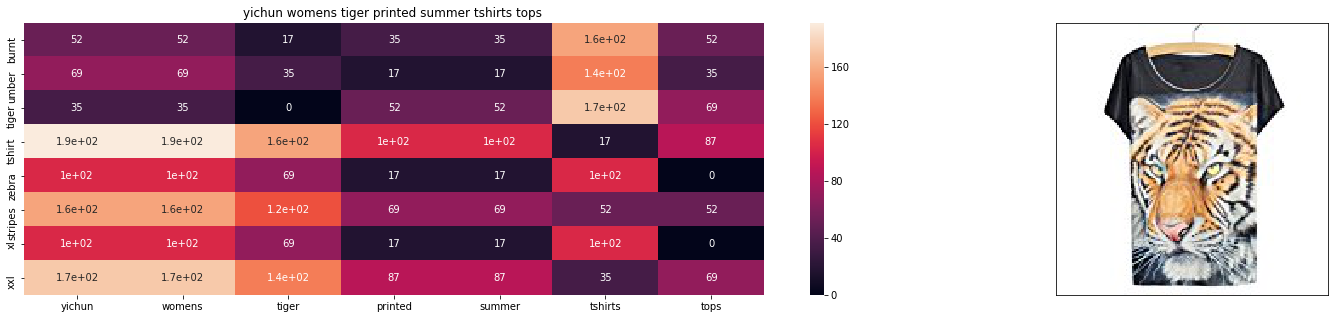

ASIN : B010NN9RXO
Brand : YICHUN
euclidean distance from input : 12.1982043805


In [2]:
#import all the necessary packages.

import PIL
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout
from gensim.models import Word2Vec
from gensim.models import KeyedVectors 
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import requests 
import pandas as pd
import pickle
from IPython.display import display, Image, SVG, Math, YouTubeVideo

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
 
data = pd.read_pickle('pickels/16k_apperal_data_preprocessed')  

#Data is sorted because after trying i came to know that data in asin file and data in "16k_apperal_data_preprocessed" file both are not with same index so in order to create sync doing this activity
data.sort_values('asin',inplace=True, ascending=True)  

asins = np.load('16k_data_cnn_feature_asins.npy')
asins= list(asins)
df_asins =list(data['asin'])

with open('word2vec_model', 'rb') as handle:
    model = pickle.load(handle) 
vocab = model.keys()

def display_img(url):
     
    response = requests.get(url)
    img = PIL.Image.open(BytesIO(response.content)) 
    plt.imshow(img)

def get_word_vec(sentence, doc_id, m_name):
    vec = []
    for i in sentence.split():
        if i in vocab:
            if m_name == 'weighted' and i in  idf_title_vectorizer.vocabulary_:
                vec.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[i]] * model[i])
            elif m_name == 'avg':
                vec.append(model[i])
        else:
            vec.append(np.zeros(shape=(300,))) 
    return  np.array(vec)

def get_distance(vec1, vec2):
    
    final_dist = []
    for i in vec1:
        dist = []
        for j in vec2: 
            dist.append(np.linalg.norm(i-j))
        final_dist.append(np.array(dist)) 
    return np.array(final_dist)

def heat_map_w2v_brand(sentance1, sentance2, url, doc_id1, doc_id2, df_id1, df_id2, model): 
    
    s1_vec = get_word_vec(sentance1, doc_id1, model)
    s2_vec = get_word_vec(sentance2, doc_id2, model) 
    s1_s2_dist = get_distance(s1_vec, s2_vec)
   
    data_matrix = [['Asin','Brand', 'Color', 'Product type'],
               [data['asin'].loc[df_id1],brands[doc_id1], colors[doc_id1],types[doc_id1]], 
               [data['asin'].loc[df_id2],brands[doc_id2], colors[doc_id2],types[doc_id2]]] 
    colorscale = [[0, '#1d004d'],[.5, '#f2e5ff'],[1, '#f2e5d1']]  
    table = ff.create_table(data_matrix, index=True, colorscale=colorscale) 
    plotly.offline.iplot(table, filename='simple_table') 
    gs = gridspec.GridSpec(25, 15)
    fig = plt.figure(figsize=(25,5))
     
    ax1 = plt.subplot(gs[:, :-5]) 
    ax1 = sns.heatmap(np.round(s1_s2_dist,6), annot=True) 
    ax1.set_xticklabels(sentance2.split()) 
    ax1.set_yticklabels(sentance1.split()) 
    ax1.set_title(sentance2) 
    
    ax2 = plt.subplot(gs[:, 10:16]) 
    ax2.grid(False)
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    display_img(url)
    
    plt.show()
    
def build_avg_vec(sentence, num_features, doc_id, m_name): 

    featureVec = np.zeros((num_features,), dtype="float32") 
    nwords = 0
    
    for word in sentence.split():
        nwords += 1
        if word in vocab:
            if m_name == 'weighted' and word in  idf_title_vectorizer.vocabulary_:
                featureVec = np.add(featureVec, idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[word]] , model[word])
            elif m_name == 'avg':
                featureVec = np.add(featureVec, model[word])
    if(nwords>0):
        featureVec = np.divide(featureVec, nwords) 
    return featureVec
 
data['brand'].fillna(value="Not given", inplace=True )


brands = [x.replace(" ", "-") for x in data['brand'].values]
types = [x.replace(" ", "-") for x in data['product_type_name'].values]
colors = [x.replace(" ", "-") for x in data['color'].values]

brand_vectorizer = CountVectorizer()
brand_features = brand_vectorizer.fit_transform(brands)

type_vectorizer = CountVectorizer()
type_features = type_vectorizer.fit_transform(types)

color_vectorizer = CountVectorizer()
color_features = color_vectorizer.fit_transform(colors)

extra_features = hstack((brand_features, type_features, color_features)).tocsr() 

bottleneck_features_train = np.load('16k_data_cnn_features.npy') 

idf_title_vectorizer = CountVectorizer()
idf_title_features = idf_title_vectorizer.fit_transform(data['title'])

doc_id = 0
w2v_title_weight = []

for i in data['title']:
    w2v_title_weight.append(build_avg_vec(i, 300, doc_id,'weighted'))
    doc_id += 1

w2v_title_weight = np.array(w2v_title_weight) 

def idf_w2v_brand(query_product_id, titlePriority, brandColorPriority, photoPriority, num_results):
    
   # doc_id = asins.index(df_asins[query_product_id]) 
    photo_wise_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[query_product_id].reshape(1,-1))
    ex_feat_dist = pairwise_distances(extra_features, extra_features[query_product_id])
    idf_w2v_dist  = pairwise_distances(w2v_title_weight, w2v_title_weight[query_product_id].reshape(1,-1))
    
   

    pairwise_dist   = ((titlePriority * idf_w2v_dist )+ ( brandColorPriority*  ex_feat_dist) +( photoPriority * photo_wise_dist))/float(titlePriority + brandColorPriority + photoPriority)  
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]      
     
    df_indices = list(data.index[indices])
    
    
    for i in range(0, len(indices)): 
        heat_map_w2v_brand(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i],df_indices[0], df_indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*125)
          
idf_w2v_brand(1416, 5,5,3, 10) 